In [1]:
import pandas as pd
import geopandas as gpd
from polygon_geohasher.polygon_geohasher import polygon_to_geohashes, geohash_to_polygon
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
df = gpd.read_file('nz.geojson')
geohashes = polygon_to_geohashes(df.geometry.loc[0], 5, inner=False)

In [ ]:
geo5s = list(geohashes)

In [ ]:
poly5s = [geohash_to_polygon(x) for x in geo5s]

In [ ]:
df2 = pd.DataFrame(list(zip(geo5s, poly5s)), columns=['geohash', 'geometry'])
df2.head()

In [ ]:
new = gpd.GeoDataFrame(df2, geometry='geometry', crs='epsg:4326')

In [ ]:
new.plot(column='geohash', cmap='turbo')

In [ ]:
new.to_file('nz.shp')

excerpt from earth engine:
```javascript
var dataset = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')
                  .filter(ee.Filter.date('2020-01-01', '2022-06-30'));
var nighttime = dataset.select('avg_rad');

var scale = nighttime.first().projection().nominalScale()

var triplets = nighttime.map(function(image) {
  return image.reduceRegions({
    collection: table5, 
    reducer: ee.Reducer.mean(), 
    scale: scale
  }).filter(ee.Filter.neq('mean', null))
    .map(function(f) { 
      return f.set('date', image.date().format('YYYY-MM-dd'));
    });
}).flatten();

var format = function(table, rowId, colId) {
  var rows = table.distinct(rowId); 
  var joined = ee.Join.saveAll('matches').apply({
    primary: rows, 
    secondary: table, 
    condition: ee.Filter.equals({
      leftField: rowId, 
      rightField: rowId
    })
  });

  return joined.map(function(row) {
      var values = ee.List(row.get('matches'))
        .map(function(feature) {
          feature = ee.Feature(feature);
          return [feature.get(colId), feature.get('mean')];
        });
      return row.select([rowId]).set(ee.Dictionary(values.flatten()));
    });
};

var result = format(triplets, 'geohash5', 'date');

Export.table.toDrive({
  collection: result,
  description: 'viirs_timeseries',
  folder: 'earthengine',
  fileNamePrefix: 'viirs_hz',
  fileFormat: 'CSV'
})
```

In [ ]:
# viirs = pd.read_csv('sample_viirs_paris.csv')
viirs = pd.read_csv('nz_scale30.csv')
viirs = viirs.iloc[:, 1:-1]
viirs['date'] = pd.to_datetime(viirs['date'])
viirs.set_index('date', inplace=True)
viirs.head()

In [36]:
k3 = pd.read_csv('viirs_hz-2.csv')
k3 = k3.iloc[:, 1:-1]
k3['date'] = pd.to_datetime(k3['date'])
k3.set_index('date', inplace=True)
k3.head()
viirs = k3.copy()

<AxesSubplot: xlabel='date'>

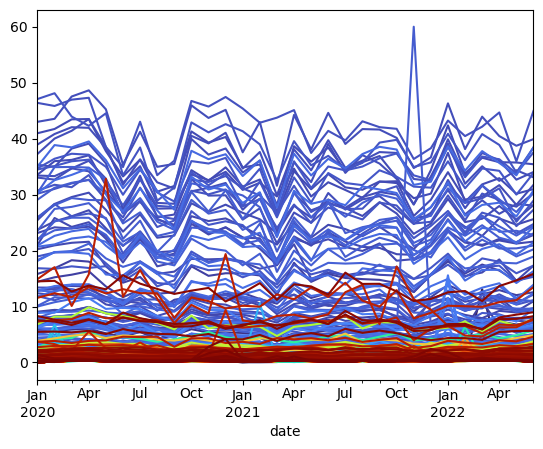

In [37]:
viirs.plot(legend=False, cmap='turbo')

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

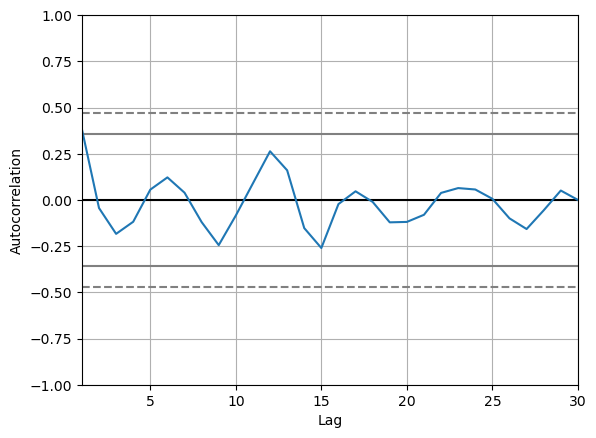

In [38]:
# test for seasonality
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(viirs.iloc[:, 1])

In [64]:
viirs_trend = viirs.apply(lambda x: seasonal_decompose(x, model='additive', extrapolate_trend=6).trend, axis=0)
viirs_seasonality = viirs.apply(lambda x: seasonal_decompose(x, model='additive', extrapolate_trend=6).seasonal, axis=0)
viirs_noise = viirs.apply(lambda x: seasonal_decompose(x, model='additive', extrapolate_trend=6).resid, axis=0)

<AxesSubplot: xlabel='date'>

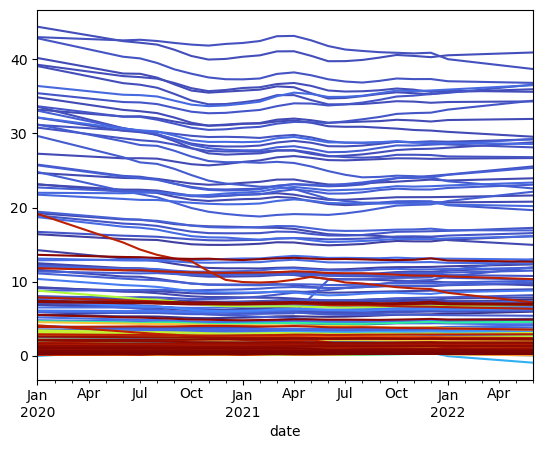

In [54]:
viirs_trend.plot(legend=False, cmap='turbo')

In [55]:
viirs_trend.head()

,k3vdz,k3vep,k3vez,k3vf9,k3vff,k3vfg,k3vfm,k3vfn,k3vfp,k3vfq,...,k3zzq,k3zzr,k3zzs,k3zzt,k3zzu,k3zzv,k3zzw,k3zzx,k3zzy,k3zzz
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.283322,0.397401,0.308148,0.229763,0.263845,0.497656,0.235649,0.239863,0.263053,0.492353,...,0.622081,0.404283,0.313595,0.275731,0.299328,0.258941,0.222487,0.266055,0.254939,0.265094
2020-02-01,0.280594,0.395758,0.302112,0.228885,0.262267,0.494194,0.236049,0.238616,0.260341,0.491132,...,0.623299,0.405706,0.313113,0.275413,0.298968,0.258774,0.236582,0.266352,0.255233,0.264134
2020-03-01,0.277866,0.394116,0.296077,0.228006,0.260689,0.490731,0.236449,0.237370,0.257629,0.489911,...,0.624518,0.407130,0.312630,0.275095,0.298608,0.258608,0.250677,0.266649,0.255528,0.263175
2020-04-01,0.275138,0.392474,0.290042,0.227127,0.259111,0.487268,0.236849,0.236123,0.254917,0.488690,...,0.625736,0.408553,0.312147,0.274778,0.298248,0.258441,0.264771,0.266946,0.255822,0.262215
2020-05-01,0.272410,0.390832,0.284006,0.226248,0.257533,0.483805,0.237248,0.234876,0.252206,0.487470,...,0.626954,0.409976,0.311665,0.274460,0.297887,0.258274,0.278866,0.267243,0.256116,0.261256


In [70]:
pop = pd.read_csv('zaf_k3_pop.csv')
pop = pop[['geohash5','_mean']]
pop.head()

,geohash5,_mean
0,k3y3b,4.423573
1,k3vws,5.778592
2,k3zs2,0.347322
3,k3y5h,1.622312
4,k3vgq,2.032644


In [65]:
viirs_trend = viirs_trend.stack().reset_index()
viirs_trend.columns = ['date', 'geohash5', 'avg_rad']
viirs_trend.head()

,date,geohash5,avg_rad
0,2020-01-01,k3vdz,0.283322
1,2020-01-01,k3vep,0.397401
2,2020-01-01,k3vez,0.308148
3,2020-01-01,k3vf9,0.229763
4,2020-01-01,k3vff,0.263845


In [106]:
merge = pd.merge(viirs_trend, pop, on='geohash5', how='left')
merge = merge.fillna(0)
merge['year'] = merge['date'].apply(lambda x: x.year)
merge['month'] = merge['date'].apply(lambda x: x.month)
merge.head()

,date,geohash5,avg_rad,_mean,year,month
0,2020-01-01,k3vdz,0.283322,0.586817,2020,1
1,2020-01-01,k3vep,0.397401,0.506310,2020,1
2,2020-01-01,k3vez,0.308148,0.000000,2020,1
3,2020-01-01,k3vf9,0.229763,0.000000,2020,1
4,2020-01-01,k3vff,0.263845,1.683507,2020,1


In [115]:
import matplotlib.pyplot as plt
import hvplot.pandas
plt.rcParams["figure.figsize"] = (20,20)

drip = merge.geohash5.unique()[:10]
merge[merge.geohash5.isin(drip)].hvplot.scatter(x='_mean', y='avg_rad', by='year', hover_cols=["geohash5", "date"], marker='o', s=80, alpha=.6, width=1000, height=1000, legend=True)

:NdOverlay   [year]
   :Scatter   [_mean]   (avg_rad,geohash5,date)

<AxesSubplot: xlabel='date'>

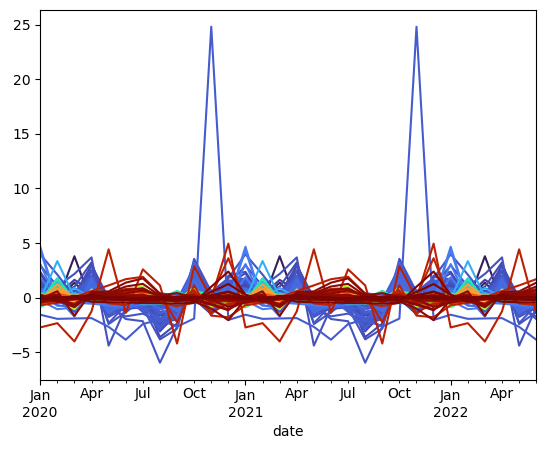

In [41]:
viirs_seasonality.plot(legend=False, cmap='turbo')

<AxesSubplot: xlabel='date'>

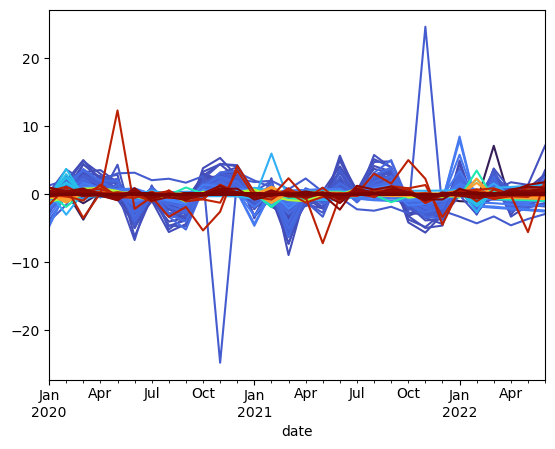

In [42]:
viirs_noise.plot(legend=False, cmap='turbo')

In [ ]:
viirs_trend.T

In [4]:
df = pd.read_csv('viirs_avgrad_ts_demo_-3.csv')
df.head()

,system:index,geohash5,iso3,mean,.geo
0,00000000000000000000,kd4dg,ZAF,0.283812,"{""type"":""Polygon"",""coordinates"":[[[26.14745959..."
1,00000000000000000001,kd97p,ZAF,0.267042,"{""type"":""Polygon"",""coordinates"":[[[24.60937291..."
2,00000000000000000002,k6qyh,ZAF,0.270032,"{""type"":""Polygon"",""coordinates"":[[[20.91796854..."
3,00000000000000000003,ketvw,ZAF,0.300104,"{""type"":""Polygon"",""coordinates"":[[[30.84960837..."
4,00000000000000000004,kdsyd,ZAF,0.277081,"{""type"":""Polygon"",""coordinates"":[[[29.31152177..."


In [5]:
df = df.iloc[:, 1:4]
df.head()

,geohash5,iso3,mean
0,kd4dg,ZAF,0.283812
1,kd97p,ZAF,0.267042
2,k6qyh,ZAF,0.270032
3,ketvw,ZAF,0.300104
4,kdsyd,ZAF,0.277081


In [6]:
df['geometry'] = df.apply(lambda x: geohash_to_polygon(x.geohash5), axis=1)

In [7]:
df.head()

,geohash5,iso3,mean,geometry
0,kd4dg,ZAF,0.283812,"POLYGON ((26.1474609375 -33.2666015625, 26.191..."
1,kd97p,ZAF,0.267042,"POLYGON ((24.5654296875 -30.41015625, 24.60937..."
2,k6qyh,ZAF,0.270032,"POLYGON ((20.91796875 -31.2890625, 20.96191406..."
3,ketvw,ZAF,0.300104,"POLYGON ((30.849609375 -24.345703125, 30.89355..."
4,kdsyd,ZAF,0.277081,"POLYGON ((29.267578125 -29.794921875, 29.31152..."


In [15]:
df.describe()

,mean
count,59612.000000
mean,0.560004
std,1.824665
min,0.201213
25%,0.266252
50%,0.279159
75%,0.330210
max,101.551018


In [8]:
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='epsg:4326')

<AxesSubplot: >

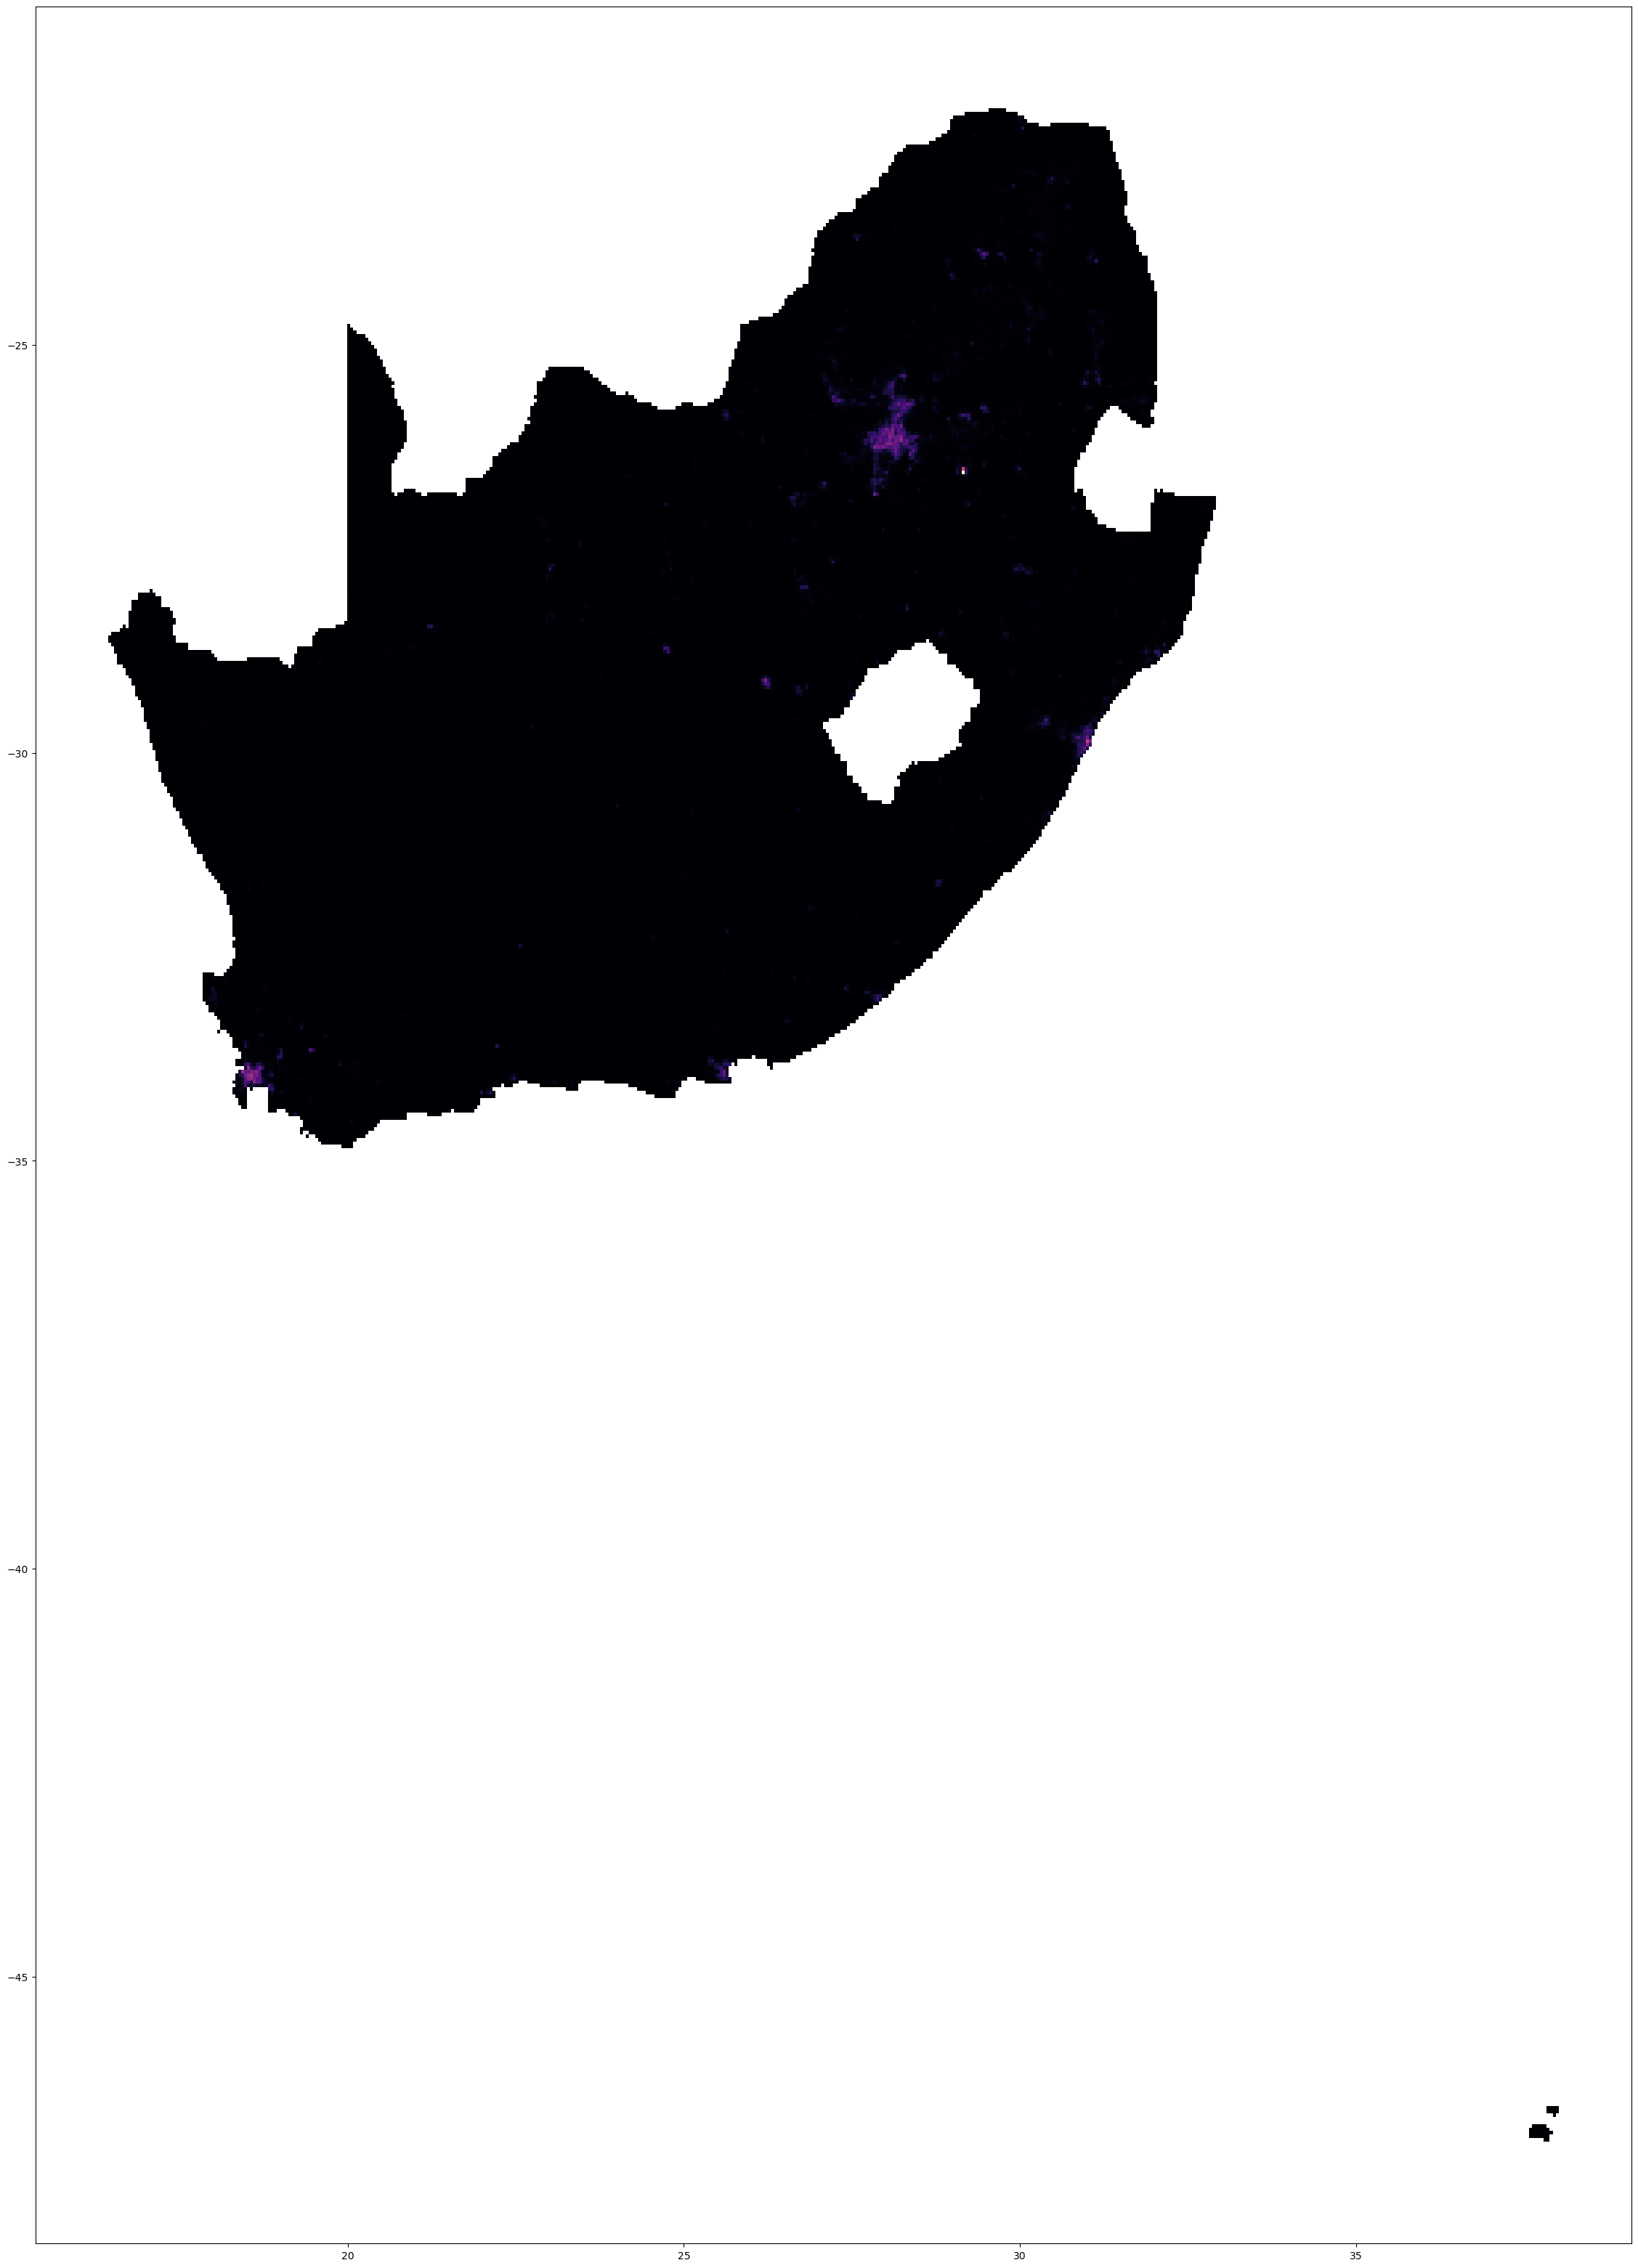

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(40, 40))

gdf.plot(ax=ax, column='mean', cmap='magma', edgecolor='None', linewidth=1)

In [32]:
k3 = pd.read_csv('viirs_hz-2.csv')
k3 = k3.iloc[:, 1:-1]
k3.head()

,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,...,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,geohash5
0,0.143353,0.334873,0.426238,0.420341,0.335379,0.339126,0.270056,0.253747,0.323021,0.372323,...,0.343726,0.345009,0.324297,0.361799,0.403445,0.435319,0.452190,0.401178,0.335886,k3vws
1,0.074692,0.235800,0.302156,0.323472,0.224408,0.250257,0.209021,0.156864,0.249919,0.302264,...,0.311269,0.312482,0.260500,0.292839,0.365999,0.370380,0.385666,0.332886,0.221939,k3vgq
2,15.822086,16.835331,18.268035,18.019636,16.128950,14.255562,15.275347,12.273913,12.548680,17.184003,...,14.179270,12.583385,15.604084,18.042768,15.893607,17.498218,16.421880,14.530096,15.566917,k3vmv
3,0.214187,0.355636,0.428905,0.465914,0.381739,0.345176,0.314777,0.306184,0.348962,0.421007,...,0.412292,0.409914,0.417306,0.378797,0.433867,0.467406,0.515096,0.459536,0.346871,k3vv0
4,34.674315,36.402721,37.294156,37.116176,34.961057,29.966977,34.468996,30.375189,28.767037,35.980781,...,37.341823,33.434775,32.571811,38.495732,33.092611,36.792433,36.311166,33.758648,37.534873,k3vpp


In [33]:
k3 = pd.read_csv('viirs_hz-2.csv')
k3 = k3.iloc[:, 1:-1]
k3['date'] = pd.to_datetime(k3['date'])
k3.set_index('date', inplace=True)
k3.head()

,k3vdz,k3vep,k3vez,k3vf9,k3vff,k3vfg,k3vfm,k3vfn,k3vfp,k3vfq,...,k3zzq,k3zzr,k3zzs,k3zzt,k3zzu,k3zzv,k3zzw,k3zzx,k3zzy,k3zzz
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.145695,0.284930,0.170605,0.114002,0.109070,0.312591,0.108237,0.097313,0.096226,0.258255,...,0.830579,0.157649,0.152544,0.096575,0.111317,0.067594,0.135267,0.067803,0.080227,0.080039
2020-02-01,0.262434,0.368001,0.278622,0.226140,0.248674,0.452918,0.208921,0.212727,0.235717,0.426186,...,0.306223,0.285839,0.313428,0.267891,0.275886,0.250768,0.265671,0.241008,0.244633,0.239473
2020-03-01,0.333923,0.451074,0.349455,0.284745,0.317387,0.537754,0.274981,0.285891,0.295272,0.514346,...,0.406203,0.355732,0.390893,0.345767,0.370519,0.326337,0.349112,0.339845,0.338437,0.343413
2020-04-01,0.353924,0.466258,0.368151,0.311035,0.334171,0.604217,0.323795,0.325419,0.323483,0.614793,...,0.369700,0.324043,0.360061,0.319283,0.340739,0.314293,0.318227,0.313664,0.310729,0.313805
2020-05-01,0.287356,0.402732,0.318260,0.240263,0.280232,0.508284,0.241678,0.259756,0.248963,0.433579,...,0.312270,0.273995,0.327696,0.284232,0.299868,0.267611,0.282265,0.259714,0.274266,0.272548


<AxesSubplot: xlabel='date'>

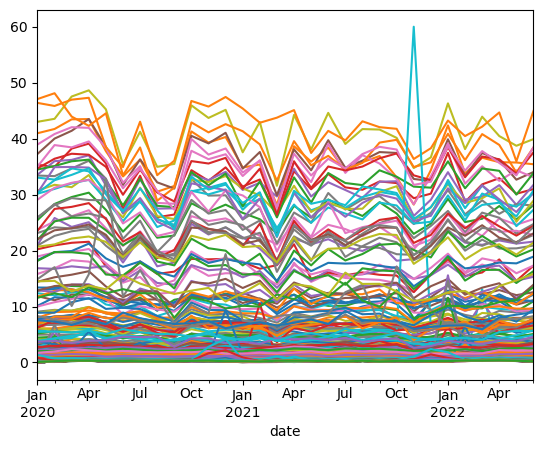

In [35]:
k3.plot(legend=False)